In [1]:
import pandas as pd
import openpyxl
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score

In [2]:
noc_roma = pd.read_csv("../NOC_ROMA_202403110800-202403111600_clusters_la.csv")

In [3]:
noc_roma["correct_label"] = noc_roma["NOTE SPV"].apply(
    lambda x: 0 if "CORRELAZIONE OK" in x else 1
)

In [4]:
noc_roma["first_occurrence"] = pd.to_datetime(noc_roma["first_occurrence"])

noc_roma = noc_roma.sort_values(by=["cluster_id", "first_occurrence"])


noc_roma["tempo_di_interarrivo"] = noc_roma.groupby("cluster_id")[
    "first_occurrence"
].diff()


noc_roma["tempo_di_interarrivo"] = noc_roma["tempo_di_interarrivo"].fillna(
    pd.Timedelta(seconds=0)
)
noc_roma["tempo_di_interarrivo"] = noc_roma["tempo_di_interarrivo"].dt.total_seconds()

## Statistics


In [5]:
noc_roma_grouped = noc_roma.groupby("cluster_id")
numero_cluster = noc_roma["cluster_id"].nunique()

cluster_corretti = []
cluster_totalmente_errati = []
cluster_parzialmente_corretti = []

for cluster_id, gruppo in noc_roma.groupby("cluster_id"):
    if gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK").all():
        cluster_corretti.append(cluster_id)
    elif gruppo["NOTE SPV"].str.contains("CORRELAZIONE ERRATA").all():
        cluster_totalmente_errati.append(cluster_id)
    else:
        cluster_parzialmente_corretti.append(cluster_id)

print("Numero Cluster:", numero_cluster)
print(f"Numero di cluster corretti: {len(cluster_corretti)}")
print(f"Numero di cluster totalmente errati: {len(cluster_totalmente_errati)}")
print(f"Numero di cluster parzialmente corretti: {len(cluster_parzialmente_corretti)}")

Numero Cluster: 35
Numero di cluster corretti: 13
Numero di cluster totalmente errati: 12
Numero di cluster parzialmente corretti: 10


## Multiple values LOC with Tempo di Interarrivo


Valori di n_neighbors :   0%|          | 0/61 [00:00<?, ?it/s]c:\VirtualEnvironment\envs\TIM_thesis\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\VirtualEnvironment\envs\TIM_thesis\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\VirtualEnvironment\envs\TIM_thesis\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\VirtualEnvironment\envs\TIM_thesis\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:

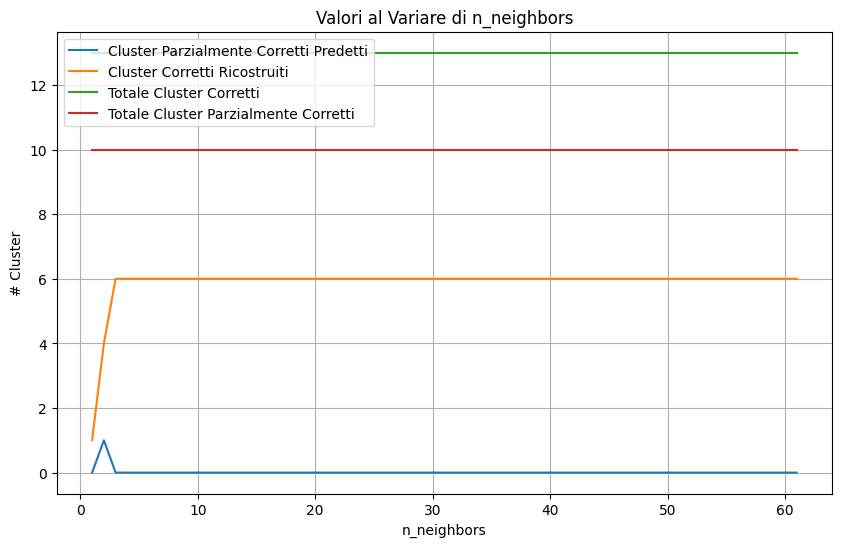

In [6]:
# Numero massimo di allarmi in un cluster
global_max_alarms = noc_roma.groupby("cluster_id").size().max()


n_neighbors_range = np.arange(1, global_max_alarms + 1, 1)


df_list = []
results = []
ari_scores = []
average_ari_scores_values = []
reconstructed_correct_clusters_values = []
partially_correct_clusters_predicted_values = []
cluster_corretti_values = []
cluster_parzialmente_corretti_values = []

for n in tqdm(n_neighbors_range, desc="Valori di n_neighbors "):

    df_list = []

    for cluster_id, group in noc_roma.groupby("cluster_id"):
        # Convertire i tempi in numeri
        X = group[["tempo_di_interarrivo"]]
        if n > len(X):
            n = len(X)

        # Applicazione del Local Outlier Factor
        lof = LocalOutlierFactor(n_neighbors=n, contamination="auto")
        labels = lof.fit_predict(X)
        true_labels_for_group = group["correct_label"].values
        if cluster_id not in cluster_totalmente_errati:
            ari_score = adjusted_rand_score(true_labels_for_group, labels)
            ari_scores.append(ari_score)

        # Creazione di un DataFrame temporaneo con i risultati
        temp_df = pd.DataFrame(
            {
                "cluster_id": cluster_id,
                "OUTLIER_LABEL": labels,
            }
        )

        df_list.append(temp_df)

    average_ari_scores_values.append(np.mean(ari_scores))
    final_df = pd.concat(df_list, ignore_index=True)
    filtered_noc_roma = noc_roma[["NOTE SPV"]]

    merge_df = pd.merge(
        final_df, filtered_noc_roma, left_index=True, right_index=True, how="left"
    )

    merge_grouped = merge_df.groupby("cluster_id")

    predict_correct_clusters = 0
    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_corretti:
            if group["OUTLIER_LABEL"].nunique() == 1:
                predict_correct_clusters += 1

    reconstructed_correct_clusters_values.append(predict_correct_clusters)
    cluster_corretti_values.append(len(cluster_corretti))

    predict_wrong_clusters = 0

    for cluster_id, group in merge_grouped:

        if cluster_id in cluster_parzialmente_corretti:
            if cluster_id in cluster_parzialmente_corretti:
                # Filtra gli allarmi con "CORRELAZIONE OK"
                allarmi_ok = group[group["NOTE SPV"].str.contains("CORRELAZIONE OK")]
                # Filtra gli allarmi con "CORRELAZIONE ERRATA"
                allarmi_errata = group[
                    group["NOTE SPV"].str.contains("CORRELAZIONE ERRATA")
                ]

                # Verifica che tutti gli allarmi OK abbiano la stessa label
                label_unica_ok = allarmi_ok["OUTLIER_LABEL"].nunique() == 1

                # Verifica che gli allarmi ERRATA abbiano una label diversa da quella degli allarmi OK
                if not allarmi_errata.empty and label_unica_ok:
                    label_ok = allarmi_ok["OUTLIER_LABEL"].iloc[0]
                    # Verifica che tutte le label ERRATA siano diverse da quella OK
                    label_diverse_errata = (
                        not allarmi_errata["OUTLIER_LABEL"].isin([label_ok]).any()
                    )

                    if label_diverse_errata:
                        predict_wrong_clusters += 1
    partially_correct_clusters_predicted_values.append(predict_wrong_clusters)
    cluster_parzialmente_corretti_values.append(len(cluster_parzialmente_corretti))


plt.figure(figsize=(10, 6))


plt.plot(
    n_neighbors_range,
    partially_correct_clusters_predicted_values,
    label="Cluster Parzialmente Corretti Predetti",
)
plt.plot(
    n_neighbors_range,
    reconstructed_correct_clusters_values,
    label="Cluster Corretti Ricostruiti",
)
plt.plot(n_neighbors_range, cluster_corretti_values, label="Totale Cluster Corretti")
plt.plot(
    n_neighbors_range,
    cluster_parzialmente_corretti_values,
    label="Totale Cluster Parzialmente Corretti",
)


plt.xlabel("n_neighbors")
plt.ylabel("# Cluster")
plt.title("Valori al Variare di n_neighbors")
plt.legend(loc="upper left")
plt.grid(True)


plt.show()

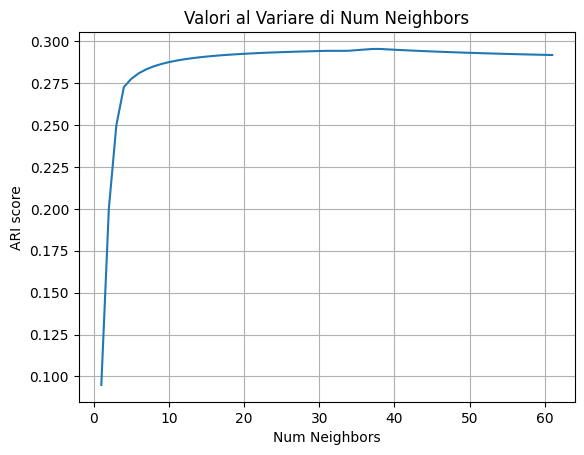

In [9]:
plt.plot(
    n_neighbors_range,
    average_ari_scores_values
)


plt.xlabel("Num Neighbors")
plt.ylabel("ARI score")
plt.title("Valori al Variare di Num Neighbors")
plt.grid(True)


plt.show()